In [1]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nmf.nmf as nmf

from sklearn.cluster import KMeans

In [11]:
df = pl.read_excel('db.xlsx')
df

#,abs_peak,abs_min,abs_max,em_peak,em_min,em_max,QY (%),hopt (%),PCE (%)
i64,i64,i64,i64,i64,i64,i64,f64,f64,f64
1,578,420,600,613,550,750,98.0,18.8,null
2,540,400,600,590,540,690,null,null,null
3,540,400,600,590,540,690,null,null,null
4,730,600,900,910,800,1000,null,2.5,null
5,730,600,900,910,800,1000,null,2.5,null
6,730,600,900,910,800,1000,null,4.0,null
7,730,600,900,910,800,1000,null,7.0,null
8,800,400,800,900,700,1000,30.0,1.4,3.2
9,600,400,600,630,600,700,50.0,0.5,1.2


In [12]:
df = df.drop(['#'])
df

abs_peak,abs_min,abs_max,em_peak,em_min,em_max,QY (%),hopt (%),PCE (%)
i64,i64,i64,i64,i64,i64,f64,f64,f64
578,420,600,613,550,750,98.0,18.8,null
540,400,600,590,540,690,null,null,null
540,400,600,590,540,690,null,null,null
730,600,900,910,800,1000,null,2.5,null
730,600,900,910,800,1000,null,2.5,null
730,600,900,910,800,1000,null,4.0,null
730,600,900,910,800,1000,null,7.0,null
800,400,800,900,700,1000,30.0,1.4,3.2
600,400,600,630,600,700,50.0,0.5,1.2


In [25]:
import re

def str2num(x:str):
    if type(x) == str:
        x = re.sub(r'%|\(| ', '', x)
        try:
            return float(x)
        except ValueError:
            parts = re.split(r'to|[-–]', x)
            try:
                num1 = float(parts[0])
                num2 = float(parts[1])
                return max(num1, num2)
            except ValueError:
                return None
    else:
        return None

In [26]:
df = df.with_columns([
    (pl.col('abs(nm)').apply(lambda x: str2num(x))).alias('abs'),
    (pl.col('p(nm)').apply(lambda x: str2num(x))).alias('p'),
    (pl.col('yield(%)').apply(lambda x: str2num(x))).alias('yield'),
    (pl.col('opt(%)').apply(lambda x: str2num(x))).alias('opt'),
    (pl.col('PCE').apply(lambda x: str2num(x))).alias('PCE(float)')
])
df

abs(nm),p(nm),yield(%),stokes(%),opt(%),PCE,abs,p,yield,opt,PCE(float)
str,str,str,i64,str,str,f64,f64,f64,f64,f64
"""420–620""","""540""","""98""",97,"""18.8""",null,620.0,540.0,98.0,18.8,null
"""420–620""","""613""","""96""",94,null,null,620.0,613.0,96.0,null,null
"""400–580""","""590""",null,95,null,null,580.0,590.0,null,null,null
"""600-950""","""750""",null,83,"""6.5""",null,950.0,750.0,null,6.5,null
"""400-900""","""870""","""30""",86,"""1.4""",null,900.0,870.0,30.0,1.4,null
"""400-650""","""625""","""50""",96,"""0.5""",null,650.0,625.0,50.0,0.5,null
"""376""","""623""","""50""",60,"""0.3""",null,376.0,623.0,50.0,0.3,null
"""300-650""","""623""","""50""",60,null,null,650.0,623.0,50.0,null,null
"""560""","""650""","""60""",86,"""2.1""",null,560.0,650.0,60.0,2.1,null


In [27]:
df = df.drop(['abs(nm)', 'p(nm)', 'yield(%)', 'opt(%)', 'PCE'])
df

stokes(%),abs,p,yield,opt,PCE(float)
i64,f64,f64,f64,f64,f64
97,620.0,540.0,98.0,18.8,null
94,620.0,613.0,96.0,null,null
95,580.0,590.0,null,null,null
83,950.0,750.0,null,6.5,null
86,900.0,870.0,30.0,1.4,null
96,650.0,625.0,50.0,0.5,null
60,376.0,623.0,50.0,0.3,null
60,650.0,623.0,50.0,null,null
86,560.0,650.0,60.0,2.1,null


In [28]:
df = df.rename({'stokes(%)': 'stokes', 'PCE(float)':'PCE'})
df = df.select([pl.col('abs'), pl.col('p'), pl.col('yield'), pl.col('stokes'), pl.col('opt'), pl.col('PCE')])
df

abs,p,yield,stokes,opt,PCE
f64,f64,f64,i64,f64,f64
620.0,540.0,98.0,97,18.8,null
620.0,613.0,96.0,94,null,null
580.0,590.0,null,95,null,null
950.0,750.0,null,83,6.5,null
900.0,870.0,30.0,86,1.4,null
650.0,625.0,50.0,96,0.5,null
376.0,623.0,50.0,60,0.3,null
650.0,623.0,50.0,60,null,null
560.0,650.0,60.0,86,2.1,null


In [29]:
total, _ = df.shape
for col in df.get_columns():
    print(f'{col.name:<6}: {col.is_null().sum()/total:.0%}')

abs   : 21%
p     : 25%
yield : 29%
stokes: 91%
opt   : 49%
PCE   : 79%


In [30]:
X = df.to_numpy()
X[np.isnan(X)] = 0
X

array([[6.20e+02, 5.40e+02, 9.80e+01, 9.70e+01, 1.88e+01, 0.00e+00],
       [6.20e+02, 6.13e+02, 9.60e+01, 9.40e+01, 0.00e+00, 0.00e+00],
       [5.80e+02, 5.90e+02, 0.00e+00, 9.50e+01, 0.00e+00, 0.00e+00],
       ...,
       [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 5.10e+00],
       [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 4.96e+00],
       [0.00e+00, 0.00e+00, 5.40e-01, 0.00e+00, 0.00e+00, 9.20e-01]])

In [31]:
Xr, W, H, cost = nmf.nmf_mu(X, k=4, seed=42)

In [32]:
print(cost)

156.15259742967928


In [33]:
Xr.dtype = np.dtype([(col, df.head().get_column(col).to_numpy().dtype) for col in df.columns])

In [34]:
df = pl.DataFrame({field_name: Xr[field_name][:,0] for field_name in Xr.dtype.fields})
df

abs,p,yield,stokes,opt,PCE
f64,f64,f64,i64,f64,f64
621.604986,539.818607,89.27917,4636472223001890232,8.01012,6.56632
621.642077,612.758385,86.534963,4636259014331266869,8.518912,6.70223
579.961607,590.010311,46.458491,4636386465031528892,7.108148,4.199281
950.36958,749.873137,27.788671,4635537176855565047,8.611584,2.315653
899.765312,870.265236,34.80946,4635760509621871716,9.670271,3.516016
650.5866,624.730313,45.157975,4636440642646751604,7.489845,4.024456
377.565497,622.640342,39.011541,4633554812630649697,6.789133,4.362748
651.175868,622.485274,40.164035,4633587754295319330,7.369762,3.45017
558.562378,650.259975,67.630042,4635791409280482923,8.160369,5.847262


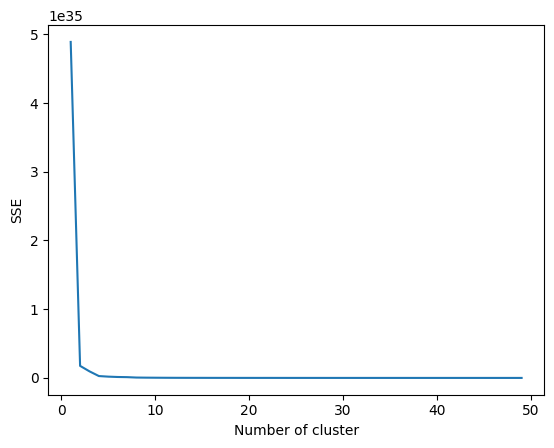

In [35]:
X = df.to_numpy()
sse = {}
for k in range(1, 50):
    kmeans = KMeans(n_clusters=k, max_iter=1000, n_init='auto').fit(X)
    #df["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()